# 6.3 卷积神经网络识别Fashion-MNIST


In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [1]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboardX import SummaryWriter
import copy
import time

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST

## 数据准备

In [4]:
## 使用FashionMNIST数据
## 准备训练数据集
train_data  = FashionMNIST(
    root = "./data/FashionMNIST", # 数据的路径
    train = True, # 只使用训练数据集
    transform  = transforms.ToTensor(),
    download= True # 如果没有数据就用True去下载数据
)
## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = False, # 每次迭代前不乱数据
    num_workers = 2, # 使用两个进程 
)
## 计算train_loader有多少个batch
print("train_loader的batch数量为:",len(train_loader))
##  获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸
print(b_x.shape)
print(b_y.shape)

## 可是使用train_loader中的前80%的batch做为训练集，剩下的batch作为验证集

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [4]:
750*64

48000

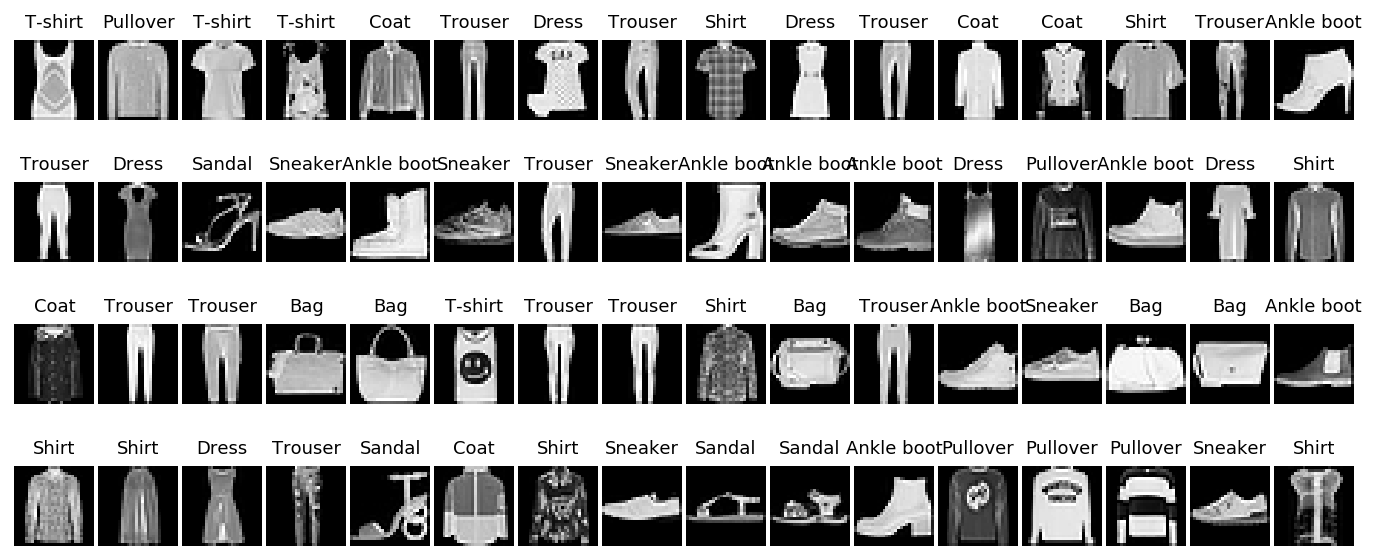

In [5]:
## 可视化一个batch的图像
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
class_label[0] = "T-shirt"
plt.figure(figsize=(12,5))
for ii in np.arange(len(batch_y)):
    plt.subplot(4,16,ii+1)
    plt.imshow(batch_x[ii,:,:],cmap=plt.cm.gray)
    plt.title(class_label[batch_y[ii]],size = 9)
    plt.axis("off")
plt.subplots_adjust(wspace = 0.05)
    

In [6]:
## 对测试集进行处理
test_data  = FashionMNIST(
    root = "./data/FashionMNIST", # 数据的路径
    train = False, # 不使用训练数据集
    download= False # 因为数据已经下载过，所以这里不再下载
)
## 为数据添加一个通道纬度,并且取值范围缩放到0～1之间
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = torch.unsqueeze(test_data_x,dim = 1)
test_data_y = test_data.targets  ## 测试集的标签

print("test_data_x.shape:",test_data_x.shape)
print("test_data_y.shape:",test_data_y.shape)

test_data_x.shape: torch.Size([10000, 1, 28, 28])
test_data_y.shape: torch.Size([10000])


## 搭建一个卷积神经网络

In [7]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet,self).__init__()
        ## 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,## 输入的feature map
                out_channels = 16,## 输出的feature map
                kernel_size = 3, ##卷积核尺寸
                stride=1,   ##卷积核步长
                padding=1, # 进行填充
            ), ## 卷积后： (1*28*28) ->(16*28*28)
            nn.ReLU(),  # 激活函数
            nn.AvgPool2d(
                kernel_size = 2,## 平均值池化层,使用 2*2
                stride=2,   ## 池化步长为2 
            ), ## 池化后：(16*28*28)->(16*14*14)
        )
        ## 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0), ## 卷积操作(16*14*14)->(32*12*12)
            nn.ReLU(),  # 激活函数
            nn.AvgPool2d(2,2) ## 最大值池化操作(32*12*12)->(32*6*6)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*6*6,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
        
    ## 定义网络的向前传播路径   
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 展平多维的卷积图层
        output = self.classifier(x)
        return output
    
## 输出我们的网络结构
myconvnet = MyConvNet()
print(myconvnet)

MyConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [8]:
## 定义网络的训练过程函数
def train_model(model,traindataloader, train_rate,criterion, optimizer, num_epochs=25):
    """
    model:网络模型；traindataloader:训练数据集，会切分为训练集和验证集
    train_rate:训练集batchsize百分比;criterion：损失函数；optimizer：优化方法；
    num_epochs:训练的轮数
    """
    ## 计算训练使用的batch数量
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    ## 复制模型的参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # 每个epoch有两个训练阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step,(b_x,b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train() ## 设置模型为训练模式
                output = model(b_x)     
                pre_lab = torch.argmax(output,1)
                loss = criterion(output, b_y) 
                optimizer.zero_grad()        
                loss.backward()       
                optimizer.step()  
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval() ## 设置模型为训练模式评估模式
                output = model(b_x)     
                pre_lab = torch.argmax(output,1)
                loss = criterion(output, b_y)  
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data) 
                val_num += b_x.size(0)
        ## 计算一个epoch在训练集和验证集上的的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f}  val Acc: {:.4f}'.format(
            epoch, val_loss_all[-1], val_acc_all[-1]))
        # 拷贝模型最高精度下的参数
        if  val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(
            time_use // 60, time_use % 60))
    # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all,
              "train_acc_all":train_acc_all,
              "val_acc_all":val_acc_all})
    return model,train_process

In [9]:
## 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.0003)  
criterion = nn.CrossEntropyLoss()   # 损失函数
myconvnet,train_process = train_model(
    myconvnet,train_loader, 0.8,
    criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
0 Train Loss: 0.7606  Train Acc: 0.7213
0 Val Loss: 0.5494  val Acc: 0.7896
Train and val complete in 0m 32s
Epoch 1/24
----------
1 Train Loss: 0.5094  Train Acc: 0.8094
1 Val Loss: 0.4698  val Acc: 0.8275
Train and val complete in 1m 19s
Epoch 2/24
----------
2 Train Loss: 0.4431  Train Acc: 0.8378
2 Val Loss: 0.4306  val Acc: 0.8407
Train and val complete in 1m 45s
Epoch 3/24
----------
3 Train Loss: 0.4009  Train Acc: 0.8535
3 Val Loss: 0.4023  val Acc: 0.8518
Train and val complete in 2m 12s
Epoch 4/24
----------
4 Train Loss: 0.3697  Train Acc: 0.8648
4 Val Loss: 0.3765  val Acc: 0.8622
Train and val complete in 2m 39s
Epoch 5/24
----------
5 Train Loss: 0.3454  Train Acc: 0.8731
5 Val Loss: 0.3562  val Acc: 0.8708
Train and val complete in 3m 5s
Epoch 6/24
----------
6 Train Loss: 0.3263  Train Acc: 0.8800
6 Val Loss: 0.3384  val Acc: 0.8776
Train and val complete in 3m 32s
Epoch 7/24
----------
7 Train Loss: 0.3104  Train Acc: 0.8861
7 Val Loss: 0.3265  va

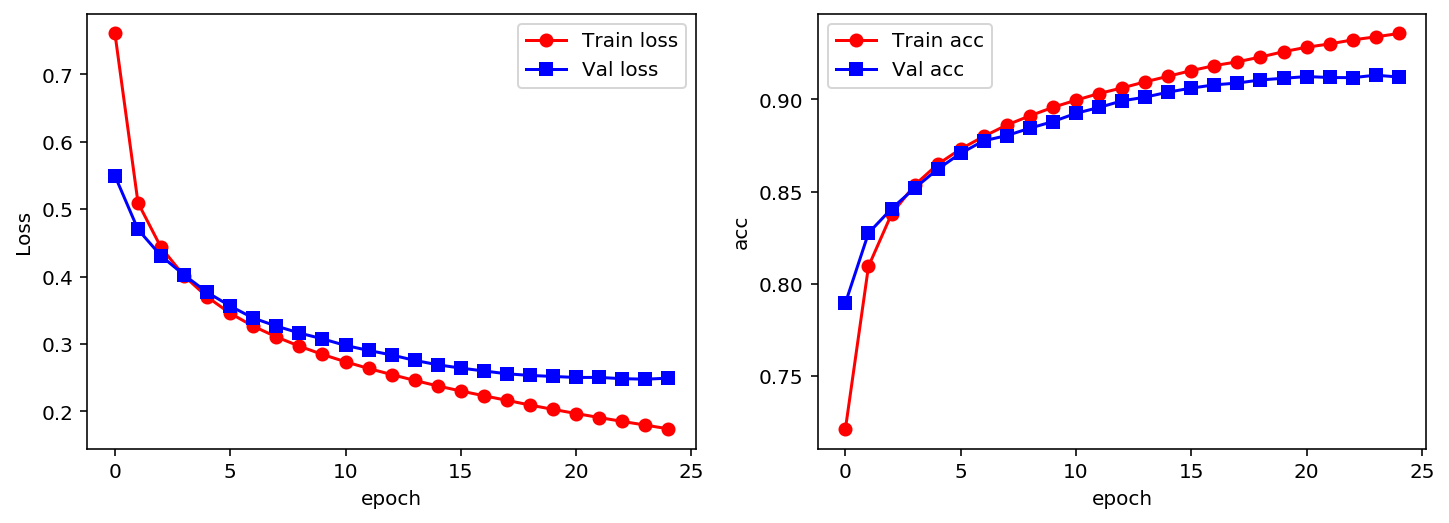

In [10]:
## 可视化模型训练过程中
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "ro-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "ro-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,
         "bs-",label = "Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [11]:
## 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output,1)
acc = accuracy_score(test_data_y,pre_lab)
print("在测试集上的预测精度为:",acc)

在测试集上的预测精度为: 0.9064


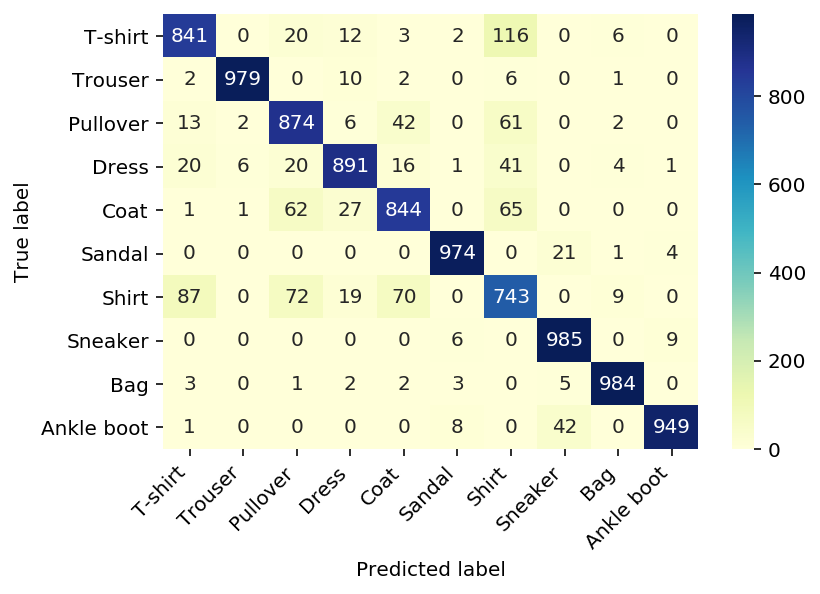

In [12]:
## 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_data_y,pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, 
                     columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 搭建一个空洞卷积模型

In [13]:
class MyConvdilaNet(nn.Module):
    def __init__(self):
        super(MyConvdilaNet,self).__init__()
        ## 定义第一个卷积层
        self.conv1 = nn.Sequential(
            ## 卷积后： (1*28*28) ->(16*26*26)
            nn.Conv2d(1,16,3,1,1,dilation=2),
            nn.ReLU(),  # 激活函数
            nn.AvgPool2d(2,2),##(16*26*26)->(16*13*13)
        )
        ## 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,0,dilation=2),## 卷积操作(16*13*13)->(32*9*9)
            nn.ReLU(),  # 激活函数
            nn.AvgPool2d(2,2) ## 最大值池化操作(32*9*9)->(32*4*4)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*4*4,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
        
    ## 定义网络的向前传播路径   
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 展平多维的卷积图层
        output = self.classifier(x)
        return output
    
## 输出我们的网络结构
myconvdilanet = MyConvdilaNet()
print(myconvdilanet)

MyConvdilaNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [14]:
## 对模型进行训练
optimizer = torch.optim.Adam(myconvdilanet.parameters(), lr=0.0003)  
criterion = nn.CrossEntropyLoss()   # 损失函数
myconvdilanet,train_process = train_model(
    myconvdilanet,train_loader, 0.8,
    criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
0 Train Loss: 0.8918  Train Acc: 0.6722
0 Val Loss: 0.6336  val Acc: 0.7546
Train and val complete in 0m 36s
Epoch 1/24
----------
1 Train Loss: 0.6075  Train Acc: 0.7680
1 Val Loss: 0.5618  val Acc: 0.7879
Train and val complete in 1m 12s
Epoch 2/24
----------
2 Train Loss: 0.5434  Train Acc: 0.7932
2 Val Loss: 0.5166  val Acc: 0.8050
Train and val complete in 1m 49s
Epoch 3/24
----------
3 Train Loss: 0.4999  Train Acc: 0.8099
3 Val Loss: 0.4841  val Acc: 0.8194
Train and val complete in 2m 23s
Epoch 4/24
----------
4 Train Loss: 0.4647  Train Acc: 0.8259
4 Val Loss: 0.4572  val Acc: 0.8316
Train and val complete in 2m 56s
Epoch 5/24
----------
5 Train Loss: 0.4355  Train Acc: 0.8391
5 Val Loss: 0.4319  val Acc: 0.8422
Train and val complete in 3m 30s
Epoch 6/24
----------
6 Train Loss: 0.4108  Train Acc: 0.8484
6 Val Loss: 0.4104  val Acc: 0.8514
Train and val complete in 4m 7s
Epoch 7/24
----------
7 Train Loss: 0.3887  Train Acc: 0.8579
7 Val Loss: 0.3896  va

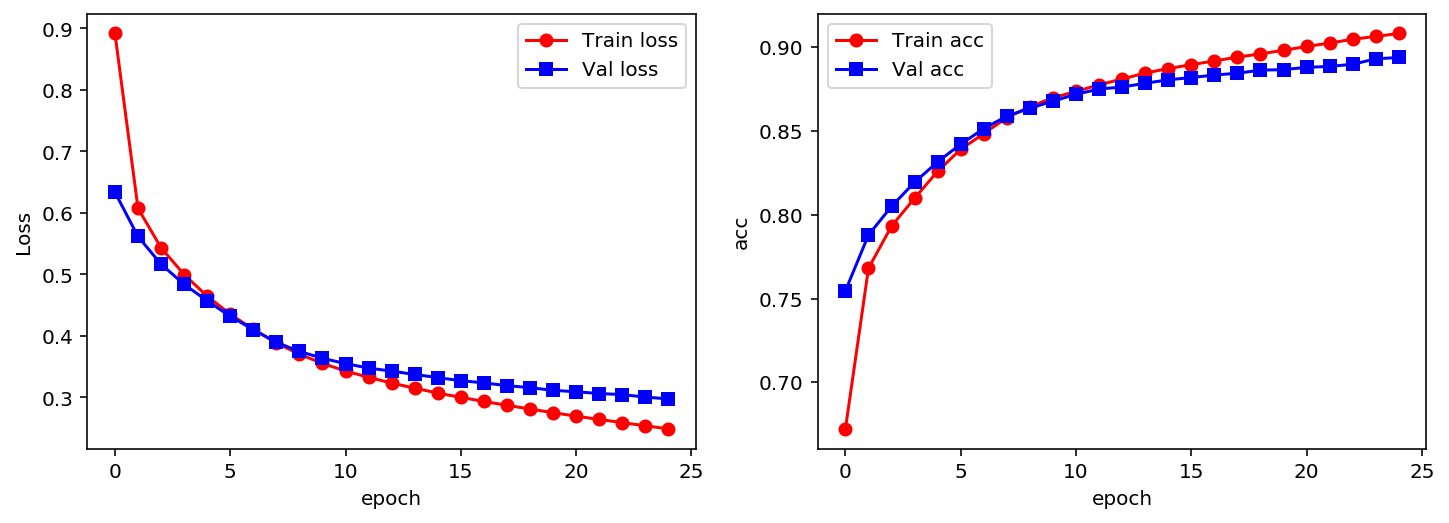

In [15]:
## 可视化模型训练过程中
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "ro-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "ro-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,
         "bs-",label = "Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

在测试集上的预测精度为: 0.8865


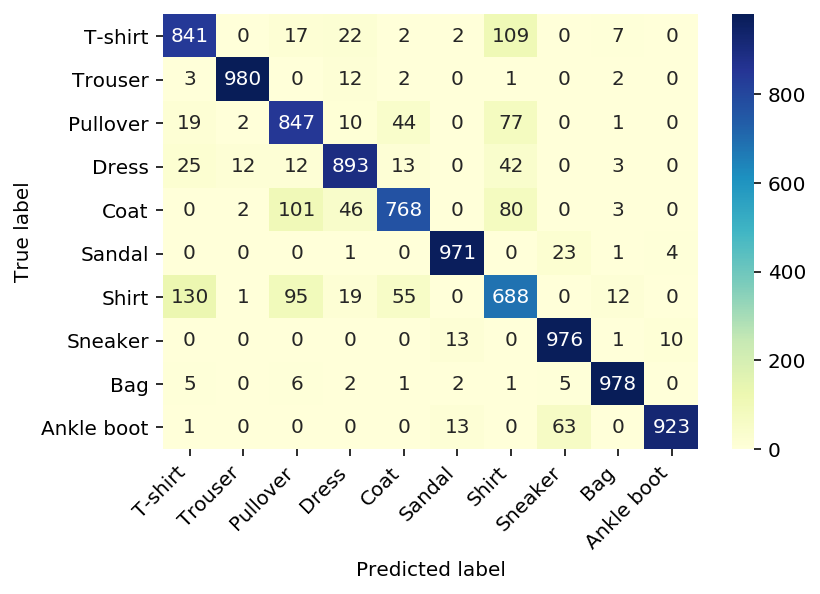

In [16]:
## 计算混淆矩阵并可视化
## 对测试集进行预测，并可视化预测效果
myconvdilanet.eval()
output = myconvdilanet(test_data_x)
pre_lab = torch.argmax(output,1)
acc = accuracy_score(test_data_y,pre_lab)
print("在测试集上的预测精度为:",acc)
conf_mat = confusion_matrix(test_data_y,pre_lab)
df_cm = pd.DataFrame(conf_mat, index=class_label, 
                     columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()